In [57]:
import torch
import torch_geometric
import torch_geometric.transforms as T
from glob import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cftime
import pickle

In [48]:
class ssp_data():
    def __init__(self, n=39) -> None:
        self.n = n
        self.init_edge_list(n)
        self.y_file = 'data\\tas_scenario_245\\tas_mon_mod_ssp245_192_000.nc'
        self.x_file_list = [item for item in glob('data\\tas_scenario_245\\tas_mon_mod_ssp245_192_*.nc') if item not in [self.y_file]][0 : self.n]
        self.create_df()
        self.test_train_split()
       
        # self.split_data()
        # self.mini_graphs()

    def init_edge_list(self, n):
        self.edge_index = []
        for i in range(n):
            for j in range(n):
                if i != j:
                    self.edge_index.append([i, j])
        self.edge_index = torch.tensor(self.edge_index, dtype=torch.long)

    def create_df(self):
        self.x = pd.DataFrame()
        i = 1
        for filename in self.x_file_list:
            print('Processing', filename)
            if self.x.empty:
                self.x = self.create_vector(filename).reset_index(drop=True)
            else:
                assert len(self.x) == len(w:= self.create_vector(filename)['tas'])
                self.x[f'tas_{i}'] = w.reset_index(drop=True)
                # self.x = self.x.merge(self.create_vector(filename), how='inner', on=['time', 'lat', 'lon'], suffixes=(None, f'_{i}'))
            
            i += 1
        
        self.y = self.create_vector(self.y_file)['tas'].reset_index(drop=True)

    def create_vector(self, filename):
        data = xr.open_dataset(filename)
        try:
            datetimeindex = data.indexes['time'].to_datetimeindex()
            data['time'] = datetimeindex
        except AttributeError:
            pass

        df = data.to_dataframe().reset_index()
        df = df.query('lat >= -44 & lat <= -12 & lon >= 288 & lon <= 336')
        ret = df.loc[(df['time'].dt.year > 1960) & (df['time'].dt.year < 1980), ['time', 'lat', 'lon', 'tas']]

        return ret
    
    def test_train_split(self, p=74100):
        df = self.x.drop(columns=['time'], axis=1)
        self.x_train = df[0:p]
        self.x_test = df[p:]
        self.y_train = df[0:p]
        self.y_test = df[p:]

        self.x_train = self.create_tensors(self.x_train).T
        self.y_train = self.create_tensors(self.y_train)
        self.train_data = torch_geometric.data.Data(x=self.x_train, edge_index=self.edge_index.t().contiguous(), y=self.y_train)

        self.x_test = self.create_tensors(self.x_test).T
        self.y_test = self.create_tensors(self.y_test)
        self.test_data = torch_geometric.data.Data(x=self.x_test, edge_index=self.edge_index.t().contiguous(), y=self.y_test)

    
    def get_device(self):
        if torch.cuda.is_available():
            device = torch.device('cuda:0')
        else:
            device = torch.device('cpu') # don't have GPU 
        return device

    def create_tensors(self, df):
        device = self.get_device()
        return torch.from_numpy(df.values).float().to(device)
    
    def mini_graphs(self):
        df = self.x
        df['x_tensor'] = df.apply(lambda row: torch.tensor(row.values.flatten()), axis=1)
        df['y'] = self.y
        df['y_tensor'] = df['y'].apply(lambda y: torch.tensor(y))
        df['data_obj'] = df.apply(lambda row: torch_geometric.data.Data(x=df['x_tensor'], edge_index=self.edge_index.t().contiguous(), y=df['y_tensor']), axis=1)
        self.batch_graphs = df['data_obj']
    
    def split_data(self):
        transform = T.Compose([T.RandomNodeSplit(num_test=1000, num_val=1000)])
        self.data = transform(self.data) 


In [55]:
ssp_obj = ssp_data(n=39)

Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_001.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_002.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_003.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_004.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_005.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_006.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_007.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_008.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_009.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_010.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_011.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_012.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_013.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_014.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_015.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_016.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_017.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_018.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_019.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_020.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_021.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_022.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_023.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_024.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_025.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_026.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_027.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_028.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_029.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_030.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_031.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_032.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_033.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_034.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_035.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_036.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_037.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_038.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_039.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\3434818901.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


In [58]:
file = open('data_pickle', 'wb')
pickle.dump(ssp_obj, file)
file.close()

In [41]:
ssp_obj.x

,lat,lon,tas,tas_2,tas_3,tas_4,tas_5,tas_6,tas_7,tas_8,...,tas_30,tas_31,tas_32,tas_33,tas_34,tas_35,tas_36,tas_37,tas_38,tas_39
0,-43.125,288.750,286.400269,280.862762,286.771332,285.407745,283.856293,284.691101,284.222473,284.567688,...,282.111908,282.265228,281.129608,286.833252,285.880707,284.140472,284.725891,284.140472,285.263153,284.725891
1,-43.125,288.750,285.905518,281.284271,281.414459,284.798828,283.674713,284.747620,284.870758,285.316010,...,281.504333,282.548706,281.564545,286.903931,284.964691,286.738007,283.592102,286.738007,286.132538,283.592102
2,-43.125,288.750,284.728638,283.605560,281.929413,282.059021,281.492584,282.372467,282.833374,285.541168,...,279.986084,280.477509,280.007172,284.080078,285.290619,281.925079,281.761536,281.925079,287.348694,281.761536
3,-43.125,288.750,280.983887,276.310425,279.923767,279.065002,278.729950,278.684601,278.864471,286.656097,...,276.463318,277.716187,277.234680,280.085754,280.959534,280.333771,279.282410,280.333771,288.668671,279.282410
4,-43.125,288.750,279.186432,272.765076,278.642639,275.679047,275.733490,275.873016,275.867615,287.312958,...,274.361664,275.168488,276.429657,277.081879,278.714783,278.002899,275.879089,278.002899,289.741669,275.879089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148195,-13.125,335.625,294.739410,295.901398,297.703033,296.290222,296.006287,296.114349,296.208649,296.394745,...,297.537598,295.884766,296.006897,296.684509,295.838593,294.373749,295.813171,294.373749,296.948700,295.813171
148196,-13.125,335.625,294.692566,295.707916,297.600006,296.493225,295.870270,295.974457,296.031311,296.582794,...,297.362488,295.818451,295.926453,296.765686,295.840881,294.300812,295.637085,294.300812,297.087402,295.637085
148197,-13.125,335.625,295.054901,296.138306,297.874847,296.958801,296.478088,296.565735,296.519348,296.831482,...,297.990479,296.596130,296.481384,297.795013,296.184540,294.528290,296.202637,294.528290,297.274567,296.202637
148198,-13.125,335.625,295.820404,297.221680,298.484406,297.945587,297.443146,297.509857,297.399323,297.165375,...,298.557434,297.636230,297.550934,299.549622,297.094421,295.460297,296.916992,295.460297,297.539337,296.916992


In [50]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.edge_weight = torch.nn.Parameter(torch.ones(ssp_obj.train_data.num_edges))
        self.conv1 = GCNConv(ssp_obj.train_data.num_node_features, 16)
        self.conv2 = GCNConv(16, ssp_obj.train_data.num_node_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index, torch.minimum(self.edge_weight.abs(),torch.ones(data.num_edges)))
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # print(x, edge_index, torch.minimum(self.edge_weight.abs(),torch.ones(data.num_edges)))
        x = self.conv2(x, edge_index, torch.minimum(self.edge_weight.abs(),torch.ones(data.num_edges)))

        return x


In [54]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
train_data = ssp_obj.train_data.to(device)
test_data = ssp_obj.test_data.to(device)
train_loss_l = []
test_loss_l = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(10000):
    optimizer.zero_grad()
    out = model(train_data)
    train_loss = F.mse_loss(out, train_data.y)
    train_loss_l.append(train_loss.item())

    test_out = model(test_data)
    test_loss = F.mse_loss(test_out, test_data.y)
    test_loss_l.append(test_loss.item())

    print(epoch, train_loss, test_loss)
    train_loss.backward()
    optimizer.step()

C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\1711369381.py:13: UserWarning: Using a target size (torch.Size([74100])) that is different to the input size (torch.Size([41, 74100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  train_loss = F.mse_loss(out, train_data.y)
C:\Users\jqcla\AppData\Local\Temp\ipykernel_8308\1711369381.py:17: UserWarning: Using a target size (torch.Size([74100])) that is different to the input size (torch.Size([41, 74100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss = F.mse_loss(test_out, test_data.y)


0 tensor(83498.4297, grad_fn=<MseLossBackward0>) tensor(86686.7656, grad_fn=<MseLossBackward0>)
1 tensor(6.3292e+10, grad_fn=<MseLossBackward0>) tensor(4.1631e+10, grad_fn=<MseLossBackward0>)
2 tensor(9.6505e+10, grad_fn=<MseLossBackward0>) tensor(1.1690e+11, grad_fn=<MseLossBackward0>)
3 tensor(6.5189e+08, grad_fn=<MseLossBackward0>) tensor(7.7834e+08, grad_fn=<MseLossBackward0>)
4 tensor(1.1292e+10, grad_fn=<MseLossBackward0>) tensor(8.5566e+09, grad_fn=<MseLossBackward0>)
5 tensor(10605637., grad_fn=<MseLossBackward0>) tensor(8295070.5000, grad_fn=<MseLossBackward0>)
6 tensor(83484.0234, grad_fn=<MseLossBackward0>) tensor(86679.7578, grad_fn=<MseLossBackward0>)
7 tensor(83490.8906, grad_fn=<MseLossBackward0>) tensor(86686.7422, grad_fn=<MseLossBackward0>)
8 tensor(83496.9141, grad_fn=<MseLossBackward0>) tensor(86692.8750, grad_fn=<MseLossBackward0>)
9 tensor(83502.2422, grad_fn=<MseLossBackward0>) tensor(86698.2969, grad_fn=<MseLossBackward0>)
10 tensor(83506.9609, grad_fn=<MseLossB

KeyboardInterrupt: 

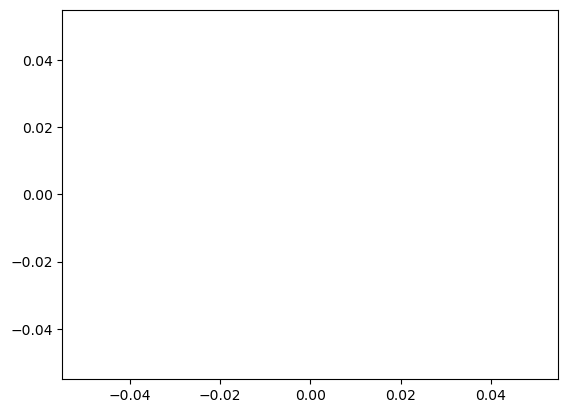

In [53]:
plt.plot(train_loss_l[5:])

In [155]:
model.edge_weight

Parameter containing:
tensor([1.0281e+00, 1.0281e+00, 1.0281e+00, 1.0281e+00, 1.0281e+00, 1.0281e+00,
        1.0281e+00, 2.3427e-01, 2.3410e-01, 2.3374e-01, 2.3368e-01, 2.3573e-01,
        2.3519e-01, 2.3605e-01, 2.3806e-01, 2.3909e-01, 2.3808e-01, 2.3746e-01,
        2.4096e-01, 2.3891e-01, 2.4134e-01, 9.2244e-01, 9.2243e-01, 9.2242e-01,
        9.2242e-01, 9.2242e-01, 9.2241e-01, 9.2243e-01, 9.2188e-01, 9.2189e-01,
        9.2188e-01, 9.2188e-01, 9.2185e-01, 9.2185e-01, 9.2186e-01, 5.6408e-04,
        5.8485e-04, 5.6915e-04, 5.9098e-04, 5.5358e-04, 5.0742e-04, 5.4165e-04,
        1.1606e-05, 1.2645e-05, 1.1900e-05, 1.3083e-05, 1.1248e-05, 8.5484e-06,
        1.0548e-05, 1.9385e-02, 1.9439e-02, 1.9907e-02, 1.9607e-02, 1.9089e-02,
        1.9989e-02, 1.9699e-02], requires_grad=True)

In [151]:
weights = model.edge_weight.tolist()
G = nx.Graph()

[1.0621346235275269,
 1.061711072921753,
 1.0619031190872192,
 1.0618290901184082,
 1.0618948936462402,
 1.0618715286254883,
 1.0617121458053589,
 1.0494590997695923,
 1.049369215965271,
 1.0494438409805298,
 1.0494590997695923,
 1.049442172050476,
 1.0494471788406372,
 1.0493615865707397,
 0.9245324730873108,
 0.9244717955589294,
 0.9245195984840393,
 0.9244185090065002,
 0.9245076179504395,
 0.9244663715362549,
 0.9243170619010925,
 0.6722093820571899,
 0.6717312335968018,
 0.6721544861793518,
 0.6738019585609436,
 0.6734118461608887,
 0.6734402775764465,
 0.6730117797851562,
 0.10454306751489639,
 0.10630414634943008,
 0.11099547147750854,
 0.10787973552942276,
 0.10195371508598328,
 0.10563800483942032,
 0.11204907298088074,
 0.6113467812538147,
 0.6118078827857971,
 0.6131083369255066,
 0.6117194294929504,
 0.6119213104248047,
 0.6113260984420776,
 0.6138107776641846,
 0.16995438933372498,
 0.1700158566236496,
 0.17485535144805908,
 0.17009152472019196,
 0.17025677859783173,
 0.16

In [108]:
model.eval()
out = model(data)
mse = F.mse_loss(out, data.y)
print(f'MSE: {mse:.4f}')

MSE: 84940.0234


C:\Users\jqcla\AppData\Local\Temp\ipykernel_17512\121057100.py:3: UserWarning: Using a target size (torch.Size([70200])) that is different to the input size (torch.Size([8, 70200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(out, data.y)


In [149]:
import networkx as nx

edge_index = ssp_data.data.edge_index
x = ssp_data.data.x

data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

nx.draw(g)


TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

In [117]:
ssp_data.data.edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
         3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
         6, 7, 7, 7, 7, 7, 7, 7],
        [1, 2, 3, 4, 5, 6, 7, 0, 2, 3, 4, 5, 6, 7, 0, 1, 3, 4, 5, 6, 7, 0, 1, 2,
         4, 5, 6, 7, 0, 1, 2, 3, 5, 6, 7, 0, 1, 2, 3, 4, 6, 7, 0, 1, 2, 3, 4, 5,
         7, 0, 1, 2, 3, 4, 5, 6]])